In [3]:
# imports for downloading files
import urllib.request
import zipfile
import os
from PIL import Image
import glob
import cv2

#  imports for the network
import torchvision, torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

In [71]:
# Get files in current working directory
files = os.listdir()


# This url points to the download of the .zip file for the masks
masks_url = "https://onedrive.live.com/download?resid=AF45414AB81A52DC%21103760&authkey=!AGJnU0iKbLqeBdM"

# This url points to the download of the .zip file for the masks
images_url = "https://onedrive.live.com/download?resid=AF45414AB81A52DC%21103761&authkey=!ADvKHy4Y3Yi7U0M"

urls =  [masks_url, images_url]

for url in urls:
    # Download the zip file
    print("Downloading zip file...")
    u = urllib.request.urlopen(url)
    data = u.read()
    u.close()

    zip_filename = ""
    if url == masks_url:
        # Specify the local filename for the downloaded zip file
        zip_filename = 'Masks.zip'
    elif url == images_url:
        # Specify the local filename for the downloaded zip file
        zip_filename = 'Images.zip'

    with open(zip_filename, 'wb') as f:
        f.write(data)

    # Unzip the downloaded file
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        # Extract all contents to the current working directory
        zip_ref.extractall()
  

In [5]:
class FireDataset(Dataset):

    def __init__(self, image_path,masks_path, transform):
        self.data = []
        self.image_path = image_path
        self.masks_path = masks_path
        self.img_dim=(3840, 2160)
        self.transform = transform

        self.image_file_list = glob.glob(self.image_path + "/*.jpg")
        self.masks_file_list = glob.glob(self.masks_path + "/*.png")

        for i in range(0,len(self.image_file_list)):
                
                img = cv2.imread(self.image_file_list[i])[..., ::-1]  # Convert BGR to RGB
                img = cv2.resize(img, self.img_dim)
                img_tensor = self.transform(img)

                mask = cv2.imread(self.masks_file_list[i], cv2.IMREAD_UNCHANGED)
                mask = mask * 255
                masks_path = cv2.resize(mask, self.img_dim)
                mask_tensor = self.transform(mask)

                self.data.append([img_tensor, mask_tensor])

    def __len__(self):
        return len(self.data)


    def get_data (self):
        return self.data

    def __getitem__(self, index):
        image, mask = self.data[index]
        return {'image': image, 'mask': mask}

Length of the Training set: 1
Length of the Validation set: 1
Length of the Testing set: 1


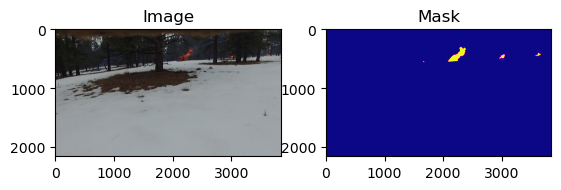

In [6]:
image_path = "Images"
mask_path = "Masks"
torch.set_printoptions(threshold=1000)
image_files = os.listdir(image_path)
mask_files = os.listdir(mask_path)

transform = transforms.Compose([transforms.ToTensor()])
dataset = FireDataset(image_path,mask_path, transform)
length = FireDataset.__len__(dataset)

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create DataLoader instances for training, validation, and testing
batch_size = 32  # You can adjust this based on your needs
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#print(train_loader.__iter__().__next__()['image'].shape)
print('Length of the Training set: '+str(len(train_data)))
print('Length of the Validation set: '+str(len(val_data)))
print('Length of the Testing set: '+str(len(test_data)))

# Printing one image and mask

# Assuming train_loader is your DataLoader
data_iterator = iter(train_loader)
batch = next(data_iterator)
image = batch['image'][0]  # Assuming you want to visualize the first image in the batch
mask = batch['mask'][0, 0]  # Assuming 'mask' is the key for your mask in the batch and it's one-dimensional

# Assuming the image and mask are in CHW format (channels, height, width)
image = image.permute(1, 2, 0)  # Change to HWC for matplotlib

# Convert the torch tensors to NumPy arrays
image = image.numpy()
mask = mask.numpy()

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='plasma')
plt.title('Mask')

plt.show()